# 1. Описание датасета

В качестве сырых данных возьмем анонимизированные данные о поездках желтых такси в Нью-Йорке.

Сырые данные о поездках в жёлтом такси можно найти на сайте TLC: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

Эти данные разбиты на файлы по месяцам.

Будем использовать информацию о поездках до мая 2016 года включительно, т.к они имеют более удобный вид для обработки.


Задача проекта — научиться предсказывать количество поездок на ближайшие сутки (24 часа) в каждом районе Нью-Йорка;

Для простоты мы поделим область Нью-Йорка сеткой 50 на 50. Поскольку в проекте нужно предсказывать 1 временной ряд, то мы выберем одну из центральных областей (под номером 1231), и будем предсказывать количество поездок именно для нее. Но в перспективе нужно работать со всеми ячейками.

Для того, чтобы это сделать, сырые данные необходимо агрегировать по часам и районам. 

Агрегированные данные будут представлять собой почасовые временные ряды с количеством поездок из каждого района.

За основу проекта брался мой недоделанный проект для Courser'ы, поэтому возможно у кого то будет такая же идея. 

# 2.Первичный анализ данных.

In [1]:
import pandas as pd 
import numpy as np 
from scipy import stats 

In [4]:
data = pd.read_csv("yellow_taxi_data\yellow_tripdata_2016-05.csv" ,sep=',', header=0, 
                   parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], infer_datetime_format=True, 
                   dayfirst=True, engine='c', encoding='cp1251')

In [13]:
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11836853 entries, 0 to 11836852
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   pickup_longitude       float64       
 6   pickup_latitude        float64       
 7   RatecodeID             int64         
 8   store_and_fwd_flag     object        
 9   dropoff_longitude      float64       
 10  dropoff_latitude       float64       
 11  payment_type           int64         
 12  fare_amount            float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  tip_amount             float64       
 16  tolls_amount           float64       
 17  improvement_surcharge  float64       
 18  total_amount        

Как видно, файл очень большой, но нас интересуют только данные о месте начала поездки и о времени, поэтому можно считывать не все данные.

В каждом из файлов содержится следующая информация о поездках:

    1. время начала поездки
    2. время окончания поездки
    5,6. долгота и широта точки начала поездки
    9,10. долгота и широта точки окончания поездки
    3. количество пассажиров
    4. расстояние по счётчику
    7. тип тарифа (одна из шести категорий)
    11. способ оплаты (одна из шести категорий)
    9. стоимость поездки по счётчику
    12. налог на счётчик
    13. доплата за поездки в пиковые часы и ночью
    14. доплата за проезд по платным дорогам
    17. доплата за проезд, взимаемая с каждой поездки с января 2015
    15. размер чаевых
    16. общая стоимость поездки
    18. Общая сумма, взимаемая с пассажиров. Не включает в себя наличные чаевые.
    9. бинарный флаг, показывающий, были ли данные о поездке получены немедленно после её окончания, или какое-то время хранились в памяти автомобиля.

In [9]:
data.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07
mean,1.529075e+00,1.662265e+00,6.110069e+00,-7.304978e+01,4.024234e+01,1.045014e+00,-7.311869e+01,4.028127e+01,1.349840e+00,1.334066e+01,3.291893e-01,4.972577e-01,1.831982e+00,3.422044e-01,2.996838e-01,1.664095e+01
std,4.991539e-01,1.304418e+00,5.155162e+03,8.212003e+00,4.523904e+00,6.203209e-01,7.902544e+00,4.353644e+00,4.942504e-01,1.188799e+01,4.585669e-01,4.473578e-02,2.665043e+00,1.760303e+00,1.300760e-02,1.450379e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-1.650819e+02,-4.456935e+01,1.000000e+00,-1.295732e+02,0.000000e+00,1.000000e+00,-4.100000e+02,-3.900000e+01,-2.700000e+00,-8.000000e+01,-1.500000e+01,-3.000000e-01,-4.103000e+02
25%,1.000000e+00,1.000000e+00,1.000000e+00,-7.399179e+01,4.073611e+01,1.000000e+00,-7.399116e+01,4.073457e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.760000e+00
50%,2.000000e+00,1.000000e+00,1.720000e+00,-7.398136e+01,4.075375e+01,1.000000e+00,-7.397922e+01,4.075439e+01,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.260000e+00,0.000000e+00,3.000000e-01,1.230000e+01
75%,2.000000e+00,2.000000e+00,3.270000e+00,-7.396588e+01,4.076862e+01,1.000000e+00,-7.396164e+01,4.077012e+01,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.836000e+01
max,2.000000e+00,9.000000e+00,1.200000e+07,1.184089e+02,5.366724e+01,9.900000e+01,0.000000e+00,7.012994e+01,5.000000e+00,8.007000e+03,7.900000e+01,4.030000e+01,7.500000e+02,1.120680e+03,3.100000e+00,8.007800e+03


In [16]:
data.shape

(11836853, 6)

За один месяц имеется почти 12 миллионов записей о поездках.

В основном данные типа float, т.к тут много информации о ценах, расстоянии и координатах.

Считаем тоже самое, но теперь только нужные столбцы.

In [51]:
data = pd.read_csv("yellow_taxi_data\yellow_tripdata_2016-05.csv" , usecols = range(1,7) ,sep=',', header=0, 
                   parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], infer_datetime_format=True, 
                   dayfirst=True, engine='c', encoding='cp1251') #считываем только нужные столбцы 

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11836853 entries, 0 to 11836852
Data columns (total 6 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        int64         
 3   trip_distance          float64       
 4   pickup_longitude       float64       
 5   pickup_latitude        float64       
dtypes: datetime64[ns](2), float64(3), int64(1)
memory usage: 541.8 MB


Тем самым, мы сократили количество использованной памяти почти в 4 раза. 

# Предобработка данных

Теперь необходимо сделать агрегацию даннных по областям Нью-Йорка. 

В данный момент данные имеют вид:

In [53]:
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192


In [198]:
New_York_rect = ((-74.25559,-73.70001), (40.49612,40.91553)) #границы Нью-Йорка 

Удалим записи которые имеют некоректные данные

In [55]:
data = data.loc[(data['passenger_count']!= 0) & (data['trip_distance']!= 0)] #число пассажиров не 0, длина поездки не 0

In [56]:
data = data.loc[(data['tpep_pickup_datetime']!=data['tpep_dropoff_datetime'])]#время начала не равно времени конца поездки

In [57]:
#поездка в границах Нью-Йорка
data = data.loc[(((data['pickup_longitude'] > New_York_rect[0][0]) & (data['pickup_longitude'] < New_York_rect[0][1]))
                &((data['pickup_latitude'] > New_York_rect[1][0]) & (data['pickup_latitude'] < New_York_rect[1][1]) ))]

In [58]:
data.shape # удалили почти 200к записей 

(11626521, 6)

In [59]:
data['hour'] = data['tpep_pickup_datetime'].dt.hour #сделаем признаки для дней и времени
data['date'] = data['tpep_pickup_datetime'].dt.date

In [60]:
def cord_to_index(data1 , data2): #функция принимает 2 серии с координатами и возвращает индекс региона
    w = (New_York_rect[0][1] - New_York_rect[0][0]) / 50 # ширина области 
    h = (New_York_rect[1][1] - New_York_rect[1][0]) / 50 # высота области 
    ind_w = (data1 - New_York_rect[0][0]) // w   #номер по ширие т.е ячейка от 0 до 49  
    ind_h = (data2 - New_York_rect[1][0]) // h   #номер по высоте т.е ячейка от 0 до 49
    #нумерация в файле regions происходит  слево-направо , снизу - вверх , 
    return 50*ind_w + ind_h + 1

In [61]:
data['region_id']= cord_to_index(data["pickup_longitude"] , data["pickup_latitude"]).astype('int')

In [62]:
data

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,hour,date,region_id
0,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,0,2016-05-01,1233
1,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,0,2016-05-01,1180
2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,0,2016-05-01,1180
3,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,0,2016-05-01,1173
4,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,0,2016-05-01,1130
...,...,...,...,...,...,...,...,...,...
11836837,2016-05-31 23:53:01,2016-06-01 00:00:24,2,1.89,-73.947876,40.774818,23,2016-05-31,1384
11836838,2016-05-31 23:53:02,2016-06-01 00:19:36,1,15.21,-73.789467,40.646942,23,2016-05-31,2068
11836839,2016-05-31 23:53:02,2016-05-31 23:59:07,1,1.80,-74.008659,40.719723,23,2016-05-31,1127
11836840,2016-05-31 23:53:03,2016-06-01 00:05:47,1,2.28,-73.981644,40.758862,23,2016-05-31,1232


In [63]:
data['region_id'].max() #есть области где нет поездок

2487

In [64]:
data_count = data.pivot_table(values =['trip_distance'] , index = ['date','hour'] , columns = ['region_id'] , aggfunc = 'count' , fill_value = 0 , margins_name = 'count')

In [65]:
data_count = data_count.rename(columns = {'trip_distance':'count'})

In [66]:
data_count.head(10)

count                                               ...       \
region_id        15   16   25   27   32   45   49   61   77   80    ... 2476   
date       hour                                                     ...        
2016-05-01 0        0    0    0    0    0    0    0    0    0    0  ...    0   
           1        0    0    0    0    0    0    0    0    0    0  ...    0   
           2        0    0    0    0    0    0    0    0    0    0  ...    0   
           3        0    0    0    0    0    0    0    0    0    0  ...    0   
           4        0    0    0    0    0    0    0    0    0    0  ...    0   
           5        0    0    0    0    0    0    0    0    0    0  ...    0   
           6        0    0    0    0    0    0    0    0    0    0  ...    0   
           7        0    0    0    0    0    0    0    0    0    0  ...    0   
           8        0    0    0    0    0    0    0    0    0    0  ...    0   
           9        0    0    0    0    0    0    0    0    0    0  ...    0   

                                                              
region_id       2478 2479 2481 2482 2483 2484 2485 2486 2487  
date       hour                                               
2016-05-01 0       0    0    0    0    0    0    0    0    0  
           1       0    0    0    0    0    0    0    0    0  
           2       0    0    0    0    0    0    0    0    0  
           3       0    0    0    0    0    0    0    0    0  
           4       0    0    0    0    0    0    0    0    0  
           5       0    0    0    0    0    0    0    0    0  
           6       0    0    0    0    0    0    0    0    0  
           7       0    0    0    0    0    0    0    0    0  
           8       0    0    0    0    0    0    0    0    0  
           9       0    0    0    0    0    0    0    0    0  

[10 rows x 1217 columns]

Сделаем нормальные индексы

In [68]:
data_count['new_date'] = data_count.index.map(lambda x: pd.datetime.datetime(x[0].year, x[0].month, x[0].day , x[1]))
data_count = data_count.set_index('new_date')

Добавим нулевые столбцы, в которых в этом месяце не было поездок.

In [71]:
# Список регионов с нулевым числом поездок
zeros_list = [('count',y) for y in list(set(range(1,2501)) - set([ x[1] for x in data_count.columns]))]
# Массив нулевых элементов по регоинам и меткам даты и времени
zeros_data = np.zeros(shape=(len(zeros_list), data_count.shape[0]), dtype=int)
# Датафрейм нулевых элементов по регоинам и меткам даты и времени
zeros_dataframe = pd.DataFrame(dict(zip(zeros_list, zeros_data)))
# Переназначение индексов
zeros_dataframe.index=data_count.index
# Расширенный датафрейм количества поездок по всем регионам и меткам даты и времени
data_count = pd.concat([data_count, zeros_dataframe], axis=1, join='inner')

In [72]:
# Сортировка столбцов
data_count = data_count.reindex(sorted(data_count.columns), axis=1)

In [73]:
data_count

count                                               ...  \
region_id            1    2    3    4    5    6    7    8    9    10    ...   
new_date                                                                ...   
2016-05-01 00:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-01 01:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-01 02:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-01 03:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-01 04:00:00     0    0    0    0    0    0    0    0    0    0  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2016-05-31 19:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-31 20:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-31 21:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-31 22:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-31 23:00:00     0    0    0    0    0    0    0    0    0    0  ...   

                                                                       
region_id           2491 2492 2493 2494 2495 2496 2497 2498 2499 2500  
new_date                                                               
2016-05-01 00:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-01 01:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-01 02:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-01 03:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-01 04:00:00    0    0    0    0    0    0    0    0    0    0  
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2016-05-31 19:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-31 20:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-31 21:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-31 22:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-31 23:00:00    0    0    0    0    0    0    0    0    0    0  

[744 rows x 2500 columns]

Теперь можно сохранить данные за месяц.

In [79]:
data_count.to_csv('timed_data//timed_yellow_tripdata_2016-05.csv' , index = True , header = False)

In [80]:
data_count

count                                               ...  \
region_id            1    2    3    4    5    6    7    8    9    10    ...   
new_date                                                                ...   
2016-05-01 00:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-01 01:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-01 02:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-01 03:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-01 04:00:00     0    0    0    0    0    0    0    0    0    0  ...   
...                   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2016-05-31 19:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-31 20:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-31 21:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-31 22:00:00     0    0    0    0    0    0    0    0    0    0  ...   
2016-05-31 23:00:00     0    0    0    0    0    0    0    0    0    0  ...   

                                                                       
region_id           2491 2492 2493 2494 2495 2496 2497 2498 2499 2500  
new_date                                                               
2016-05-01 00:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-01 01:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-01 02:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-01 03:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-01 04:00:00    0    0    0    0    0    0    0    0    0    0  
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2016-05-31 19:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-31 20:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-31 21:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-31 22:00:00    0    0    0    0    0    0    0    0    0    0  
2016-05-31 23:00:00    0    0    0    0    0    0    0    0    0    0  

[744 rows x 2500 columns]

Чтобы было удобно обрабатывать файлы разных месяцев, оьбъединим все в 1 общую функцию.

In [132]:
def prepare_data(filename , src_dir,  des_dir):
    data = pd.read_csv(os.path.join(src_dir,filename) , usecols = range(1,7),sep=',', header=0, 
                   parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], infer_datetime_format=True, 
                   dayfirst=True, engine='c', encoding='cp1251') #считываем только нужные столбцы 
    
    New_York_rect = ((-74.25559,-73.70001), (40.49612,40.91553))
    #число пассажиров не 0, длина поездки не 0
    data = data.loc[(data['passenger_count']!= 0) & (data['trip_distance']!= 0)] 
    
    #время начала не равно времени конца поездки
    data = data.loc[(data['tpep_pickup_datetime']!=data['tpep_dropoff_datetime'])]

    #поездка в границах Нью-Йорка
    data = data.loc[(((data['pickup_longitude'] > New_York_rect[0][0]) &
                      (data['pickup_longitude'] < New_York_rect[0][1]))&
                     ((data['pickup_latitude'] > New_York_rect[1][0]) &
                      (data['pickup_latitude'] < New_York_rect[1][1]) ))]
    
    data['hour'] = data['tpep_pickup_datetime'].dt.hour
    data['date'] = data['tpep_pickup_datetime'].dt.date
    
    data['region_id']= cord_to_index(data["pickup_longitude"] , data["pickup_latitude"]).astype('int')
    
    data_count = data.pivot_table(values =['trip_distance'] , index = ['date','hour'] , columns = ['region_id'] , \
                                  aggfunc = 'count' , fill_value = 0)
    
    data_count = data_count.rename(columns = {'trip_distance':'count'})
    
    data_count['new_date'] = data_count.index.map(lambda x: pd.datetime.datetime(x[0].year, x[0].month, x[0].day , x[1]))
    data_count = data_count.set_index('new_date')

    # Список регионов с нулевым числом поездок
    zeros_list = [('count',y) for y in list(set(range(1,2501)) - set([ x[1] for x in data_count.columns]))]
    # Массив нулевых элементов по регоинам и меткам даты и времени
    zeros_data = np.zeros(shape=(len(zeros_list), data_count.shape[0]), dtype=int)
    # Датафрейм нулевых элементов по регоинам и меткам даты и времени
    zeros_dataframe = pd.DataFrame(dict(zip(zeros_list, zeros_data)))
    # Переназначение индексов
    zeros_dataframe.index=data_count.index
    # Расширенный датафрейм количества поездок по всем регионам и меткам даты и времени
    data_count = pd.concat([data_count, zeros_dataframe], axis=1, join='inner')
    
    data_count = data_count.reindex(sorted(data_count.columns), axis=1)
    
    data_count.to_csv(os.path.join(des_dir ,'timed_' + filename) , index = True , header = False)
    

Обработаем еще несколько месяцев

In [8]:
import tqdm

In [7]:
src_dir = 'yellow_taxi_data'
des_dir = 'timed_data'

In [138]:
for filename in tqdm.tqdm(os.listdir(src_dir)[2:]):
    prepare_data(filename , src_dir,  des_dir)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [06:15<00:00, 62.54s/it]


# Визуальный анализ данных

Подключим нужные библиотеки

In [191]:
import os
import matplotlib.pyplot as plt
import matplotlib
import conda
import folium
import seaborn as sns 
import matplotlib.ticker as ticker
import matplotlib , branca

from matplotlib import cm
from matplotlib.colors import ListedColormap
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

plt.style.use('ggplot')

In [192]:
%matplotlib inline
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap

In [193]:
import warnings #отключаем предупреждения 
warnings.filterwarnings("ignore")

Будем использовать 4 месяца. С 2016-02 по 2016-05.

In [8]:
datas = []

In [9]:
for filename in os.listdir(des_dir)[1:5]:
    data = pd.read_csv(os.path.join(des_dir,filename), header = None,
                       index_col = 0,parse_dates=[0], infer_datetime_format=True, 
                       engine='c', encoding='cp1251')
    
    datas.append(data)

In [10]:
full_data = pd.concat(datas)

In [11]:
full_data

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,,,,,,,,,,,,,,,,,,,,,
2016-02-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 19:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-31 20:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-31 21:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Для начала отрисуем график числа поездок из выбранной нами области.

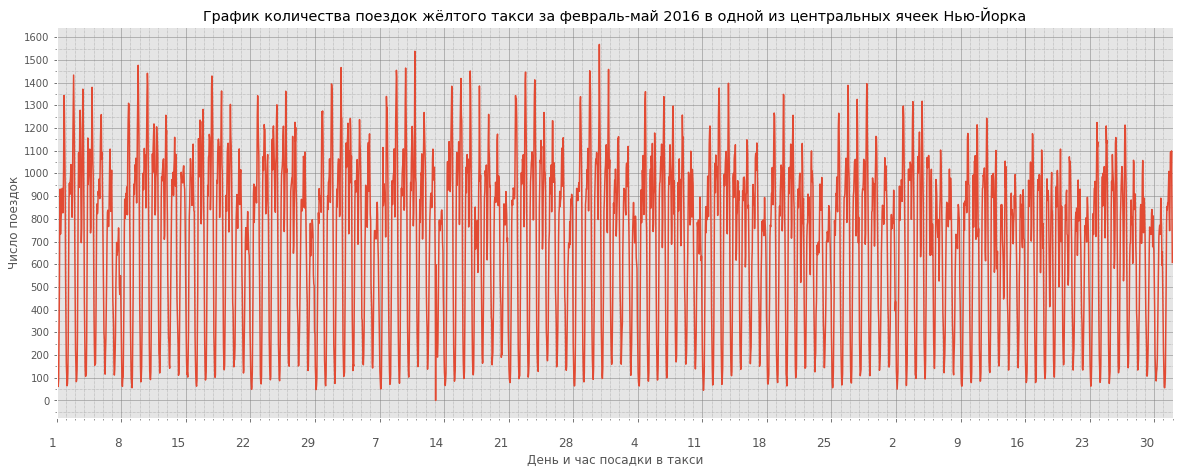

In [182]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(range(full_data.shape[0]) , full_data[1231])

ax.set_xlabel(xlabel='День и час посадки в такси')
ax.set_ylabel(ylabel='Число поездок')

ax.set_title('График количества поездок жёлтого такси за февраль-май 2016 в одной из центральных ячеек Нью-Йорка')

ax.xaxis.set_major_locator(ticker.MultipleLocator(168))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(24))

ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(50))

ax.grid(which='major', axis='both', color = 'gray', linewidth='0.5', linestyle='-')
ax.grid(which='minor', axis='both', color = 'gray', linewidth='0.5', linestyle=':')

ax.set_xlim(0, full_data.shape[0])

ax.set_xticklabels([0] + [x.day for x in full_data.index.date][::168], minor=False, fontdict={'fontsize':12})

ax.tick_params(axis='x', which='minor', pad=0)
ax.tick_params(axis='x', which='major', pad=15)

fig.autofmt_xdate(bottom=0.2, rotation=0, which='minor')
fig.autofmt_xdate(bottom=0.2, rotation=0, which='major')

plt.show()

Вывод : из этого графика явно видно выраженную дневную и недельную сезонность. 

Это логично, люди чаще пользуются такси в вечерное время (как и в будние дни).

Поскольку ряд имеет сезонность, он не является стационарным. 

Визуально в течении первых 3х месяцев среднее значение и дисперсия ряда выглядят постоянно.

Но вот в мае, значения становятся чуть меньшье (также как и дисперсия).

Возможно это связано с тем, что в мае уже достаточно тепло, чтобы ходить пешком).

Скорее всего это следствие годовой сезонности, которую мы не можем рассмотреть на отрезке в несколько месяцев.

Появляется отличная возможнось с помощью статистических критериев проверить гипотезу о равенстве среднего числа поездок за май месяц и числа поездок за предыдущие месяцы.

Посмотрим какое распределение имеет число поездок за весь этот период.

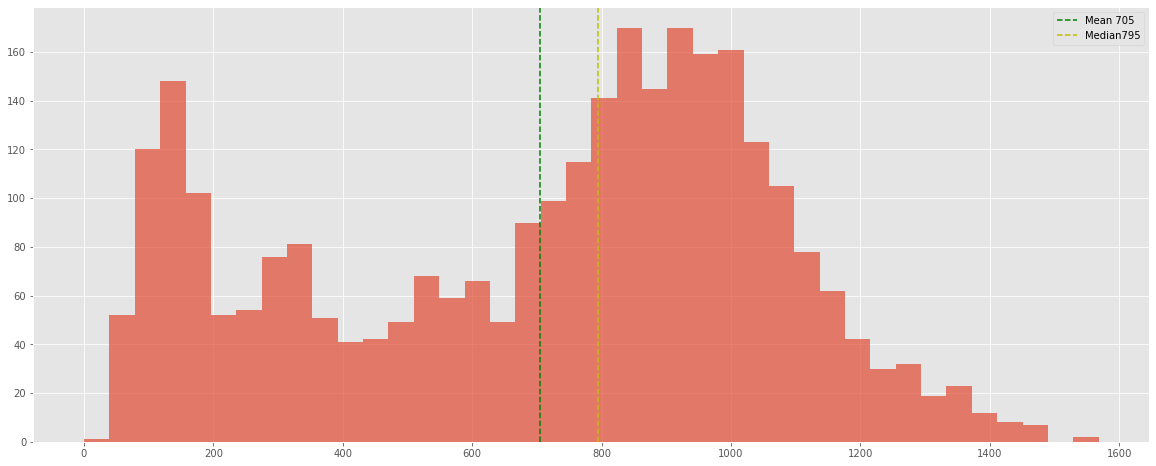

In [30]:
full_data[1231].hist(bins=40,figsize=(20,8), alpha=0.7)
plt.axvline(x=full_data[1231].mean(), c='g', label='Mean ' + str(round(full_data[1231].mean())), linestyle='dashed')
plt.axvline(x=full_data[1231].median(), c='y', label='Median' + str(round(full_data[1231].median())), linestyle='dashed')
plt.legend()

Видно, что оно имеет несколько пиков, а точнее 2 основных пика. Основная масса приходится на большие значения (около 1000).

Распределение совсем не похоже на нормальное.

Среднее сильно отличается от мод. 

Можем сказать, что чаще всего люди используют такси либо "мало", либо "много".

Теперь взгляним на картину в общем  и поиграемся с картами.

Отрисуем суммарное количество поездок за май.

In [186]:
sum_data = np.sum(full_data , axis = 0)#суммируем число поездок 
sum_data= (np.array(sum_data).reshape((50,50))).T

#широты и высоты областей 
lx = np.linspace(New_York_rect[0][0] ,New_York_rect[0][1],51)
ly = np.linspace(New_York_rect[1][0] ,New_York_rect[1][1],51)
#сетка в координатах Земли 
xx , yy = np.meshgrid(lx,ly)

In [202]:
center = [np.mean(cor) for cor in New_York_rect] #центр 

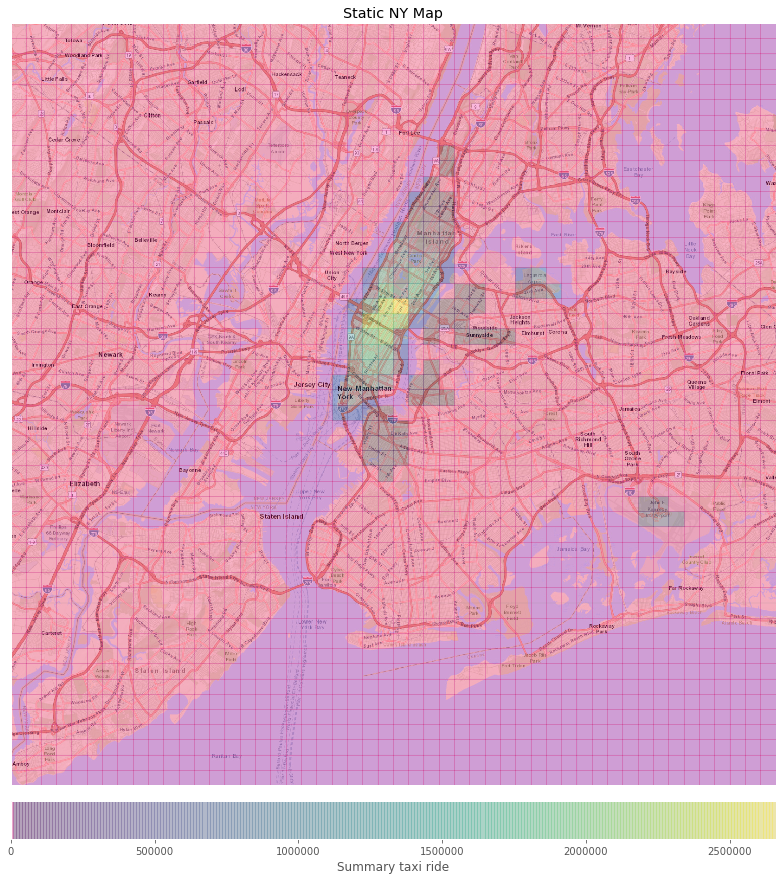

In [190]:
fig = plt.figure(num=None, figsize=(15, 15)) 
#создаем карту 
map_basemap = Basemap(llcrnrlat=(New_York_rect[1][0]),
                      llcrnrlon=(New_York_rect[0][0]), 
                      urcrnrlat=(New_York_rect[1][1]),
                      urcrnrlon=(New_York_rect[0][1]), 
                      resolution='f',
                      projection='lcc',
                      area_thresh=5000,
                      lat_0=center[0],
                      lon_0=center[1],
                      epsg=3857
                     )

my_cmap = plt.get_cmap('viridis' , 256)

newcolors = my_cmap(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)


#сетка в координатах графика 
llx, lly = map_basemap(xx, yy)

colormesh = map_basemap.pcolormesh(llx,lly, data = sum_data,cmap = newcmp , alpha  = 0.3 )
cb = map_basemap.colorbar(colormesh, location='bottom', label="Summary taxi ride")


#выбираем текстуру города 
map_basemap.arcgisimage(service='World_Street_Map', xpixels=1500)

#отрисуем границы областей 
map_basemap.drawparallels(np.linspace(New_York_rect[1][0] ,New_York_rect[1][1],51) ,linewidth=0.25, color='0.5')
map_basemap.drawmeridians(np.linspace(New_York_rect[0][0] ,New_York_rect[0][1],51) , linewidth=0.25, color='0.5')

plt.title("Static NY Map")

plt.show()

Отрисуем среднее в час количество поездок за май.

In [194]:
mean_data = np.array(np.mean(full_data , axis = 0)).reshape((50,50)).T #находим среднее число поездок 

In [195]:
def get_geojson_grid(upper_right, lower_left, mean_matrix, n=50):
#Создает сетку в формате GeoJson, чтобы дальше отрисовать ее с помощью folium 
#Аргументы : Правый верхний угол ,Нижний левый, Матрица со средним числом поездок,на сколько частей разбивать 
    
    geo_json = {"type": "FeatureCollection",
                "features":[]}

        
    lat_steps = np.linspace(lower_left[0], upper_right[0], n+1)
    lon_steps = np.linspace(lower_left[1], upper_right[1], n+1)

    lat_stride = lat_steps[1] - lat_steps[0]
    lon_stride = lon_steps[1] - lon_steps[0]

    for i , lat in enumerate(lat_steps[:-1]):
        for k , lon in enumerate(lon_steps[:-1]):
            # Define dimensions of box in grid
            upper_left = [lon, lat + lat_stride]
            upper_right = [lon + lon_stride, lat + lat_stride]
            lower_right = [lon + lon_stride, lat]
            lower_left = [lon, lat]

            # Define json coordinates for polygon
            coordinates = [
                upper_left,
                upper_right,
                lower_right,
                lower_left,
                upper_left
            ]

            grid_feature = {
                "type":"Feature",
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [coordinates],
                },
              "properties":{
                  "mean": mean_matrix[i][k]
              },
            }

            geo_json["features"].append(grid_feature)


    return geo_json

In [196]:
#создаем палитру для отрисовки 
colormap = branca.colormap.LinearColormap(colors=['white','yellow' ,'green','red'], index=[0,5,50,np.max(mean_data)], 
                                          vmin = 0 ,vmax = np.max(mean_data))
colormap

Начиная с 5 поездок среднее будет показываться желтым цветом , c 50 - зеленым.

In [199]:
upper_right  = [New_York_rect[1][1] , New_York_rect[0][1]]
lower_left =  [New_York_rect[1][0] , New_York_rect[0][0]]
grid = get_geojson_grid(upper_right,lower_left, mean_data, n=50)

In [200]:
gj = folium.GeoJson(grid, style_function=lambda x: {#'fillColor': colorscale(x["properties"]["mean"]),
                                            'color':colormap(x["properties"]["mean"]),
                                            'weight': 1,
                                            'dashArray': '5, 5',
                                            'opacity': 0.6,
                                            'fillOpacity': 0.5,
                                            }, name="Mean Taxi Ride")

In [212]:
# Create a map
m_NY = folium.Map(location=center[::-1], tiles='openstreetmap', zoom_start=10)

In [213]:
our_cell = [40.748391, -73.985543] #координаты нашей ячейки

In [214]:
Marker(our_cell).add_to(m_NY) #Добавляем маркер нашей ячейки

In [215]:
m_NY.add_child(gj)

Получили красивую карту. 

Судя по карте основная масса поездок приходится на Манхэттен. Что логично, т.к это деловой центр города.

Но также достаточное количество поездок приходится на аэропорты. 

Ячеек из неадекватных мест(водоемов и т.д) вроде бы нет, так что скорее всего мы все сделали правильно.

Теперь разложим ряд на компоненты и отрисуем STL декомпозицию.

In [107]:
import statsmodels.api as sm
from pylab import rcParams

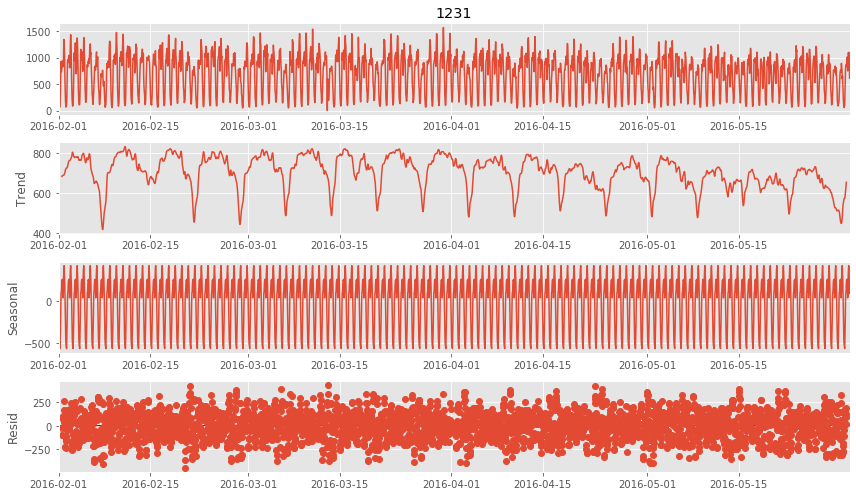

In [189]:
rcParams['figure.figsize'] = 12, 7
sm.tsa.seasonal_decompose(full_data[1231]).plot()
plt.show()

Вывод: 
    
Визуально ряд не имеет ярко выраженного тренда. Значения колеблются в одних и тех же пределах.

Но в майский месяц значения более сжаты, будто дисперсия рядо уменьшилась.

Сезонная компонента состоит из дневной сезонности.

Недельняя сезонность ушла в тренд. Видно как тренд раскладывается на отрезки, где минимумы приходятся на выходные дни.


# Проверка гипотез

In [200]:
from scipy import stats

1. Проверим гипотеу о стационарности ряда с помощью Критерия Дики-Фулера.
2. Убедимся в том что данные имеют не нормальное распределение.
3. Проверим гипотезу о равенсте среднего числа поездок в мае и предыдущих месяцах.
4. Попарно сравним средние разных месяцев (множественная проверка гипотез).

### 1. Стационарность ряда

Возьмем функцию с лекции.

In [198]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

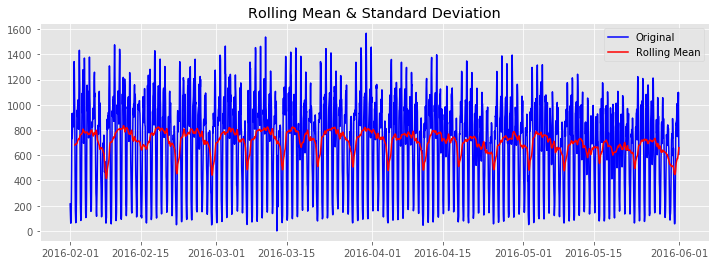

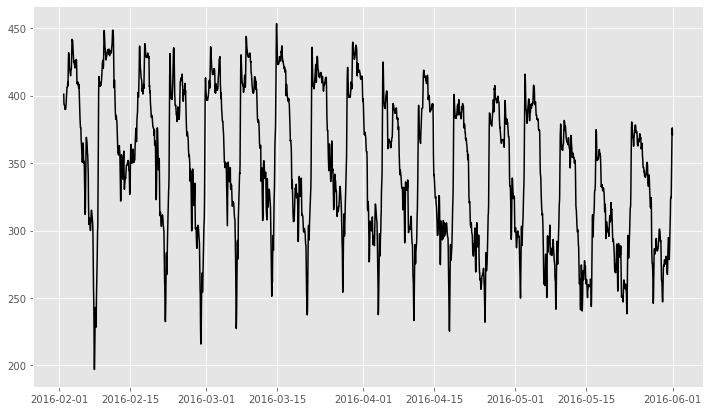

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.794182e+00
p-value                        2.323501e-09
#Lags Used                     2.800000e+01
Number of Observations Used    2.875000e+03
Critical Value (1%)           -3.432627e+00
Critical Value (5%)           -2.862546e+00
Critical Value (10%)          -2.567305e+00
dtype: float64


In [199]:
test_stationarity(full_data[1231])

Исходя из критерия Дики-Фулера, получается что ряд стационарен (т.к значение p-value 2.323501e-09).

Но мы знаем, что это не так, т.к есть сезонность.

Возможно, он не сработал из-за большой зашумленности данных.

### 2. Нормальность данных

Визуально, очевидно, что данные распределены не нормально, но давайте в этом убедимся с помощью критерия 
Шапиро-Уилка:

$H_0\colon$ данные распределны нормально.

$H_1\colon$ не нормально.

In [40]:
stats.shapiro(full_data[1231])

ShapiroResult(statistic=0.9452146887779236, pvalue=1.4312167991741817e-31)

Критерий уверенно отвергает нулевую гипотезу в пользу альтернативу, с достигаемым уровнем значимости pvalue=1.4312167991741817e-31.

Мы убедились, что данные распределны не нормально.

### 3. Среднее число поездок

Сначала просто посмотрим на средние.

In [38]:
for i in range(2,6):
    print(f'Mean Count of Ride in {i} month: {full_data[1231][full_data.index.month==i].mean()}')
print('Full mean:',full_data[1231].mean())

Mean Count of Ride in 2 month: 722.125
Mean Count of Ride in 3 month: 740.8494623655914
Mean Count of Ride in 4 month: 700.8013888888889
Mean Count of Ride in 5 month: 657.9153225806451
Full mean: 705.1849173553719


Видно что в мае среднее прилично меньше.

In [42]:
full_data[1231][full_data.index.month==5].std(), full_data[1231][full_data.index.month!=5].std()

(320.7736435098047, 364.34509164835004)

Дисперсии также отличаются.

Далее, будем проверять гипотезу о равенсте среднего числа поездок против двусторонней альтернативы.
(Вместо того, чтобы брать одностороннюю альтернативу).

Это делается для того, чтобы мы не переобучалсь, т.к мы уже видели данные и знаем, что среднее скорее всего меньше.

Попробуем использовать Критерий Стьюдента, для проверки гипотезы о том, что среднее количество поездок за май не равно среднему количеству поездок за предыдущие месяцы.

H0: число заказов в мае равно числу заказов за 2-4 месяц.

H1: число заказов в мае не равно числу заказов за 2-4 месяц.

Хотя он и требует нормальности данных и равенства дисперсий, посмотрим на результаты.

In [43]:
t_stat = stats.ttest_ind(full_data[1231][full_data.index.month==5], full_data[1231][full_data.index.month!=5])

In [44]:
t_stat

Ttest_indResult(statistic=-4.226719605985014, pvalue=2.444402377784712e-05)

Критерий уверенно отвергает нулевую гипотезу в пользу альтернативу, с достигаемым уровнем значимости pvalue=2.444402377784712e-05.

Критерий говорит, что средние значения все таки различны.

Но чтобы быть уверенными в результатах, используем критерий, который не требует никаких дполнительных условий от данных.

Воспользуем одним из непараметрических критериев - Критерием Манна-Уитни.

In [51]:
stats.mannwhitneyu(full_data[1231][full_data.index.month==5], full_data[1231][full_data.index.month!=5])

MannwhitneyuResult(statistic=701769.5, pvalue=1.2434458841687715e-07)

Критерий также уверенно отвергает нулевую гипотезу, с достигаемым уровнем значимости pvalue=1.2434458841687715e-07.

Можем сделать вывод: число поездок в мае значительно уменьшилось.

### 4. Множественная проверка гипотез

In [50]:
from statsmodels.sandbox.stats.multicomp import multipletests 

Проведем попарные тесты на равенство средних.

In [57]:
stat_data = []

for i in range(2,6):
    for j in range(2,6):
        if i >= j:
            continue
        
        stat, p = stats.mannwhitneyu(full_data[1231][full_data.index.month==i], full_data[1231][full_data.index.month==j])
        stat_data.append([i, j, p])

In [58]:
stat_data = pd.DataFrame(stat_data, columns=['month_1', 'month_2', 'p_val'])

In [59]:
stat_data

,month_1,month_2,p_val
0,2,3,1.942510e-01
1,2,4,4.317316e-02
2,2,5,7.558823e-06
3,3,4,4.385482e-03
4,3,5,3.848086e-08
5,4,5,2.150166e-03


С помощью Критерия Манна-Уитни посчитали p-value, для гипотез о равенстве средних.

Теперь применим Метод Холма для поправки на множественную проверку гипотез.

In [60]:
reject, p_corrected, a1, a2 = multipletests(stat_data.p_val, 
                                            alpha = 0.05, 
                                            method = 'holm') 

In [61]:
stat_data['p_corrected'] = p_corrected
stat_data['reject'] = reject

In [62]:
stat_data

,month_1,month_2,p_val,p_corrected,reject
0,2,3,1.942510e-01,1.942510e-01,False
1,2,4,4.317316e-02,8.634632e-02,False
2,2,5,7.558823e-06,3.779411e-05,True
3,3,4,4.385482e-03,1.315645e-02,True
4,3,5,3.848086e-08,2.308852e-07,True
5,4,5,2.150166e-03,8.600663e-03,True


Как видно, гипотезы о равенстве средних отклоняются, для случаев кроме 2-3, 2-4 месяца. 

В остальных же случаях считаем, что средние не равны.

Интересно, что средние 2-3, 2-4 равны, а 3-4 нет.

# Предсказание временного ряда.

Будем делать предсказания спроса на такси на ближайшие сутки.

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt
    
def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse

In [13]:
# Относительная ошибка - хорошая метрика для бизнеса
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import TimeSeriesSplit 

Наивный baseline

In [15]:
w_hours = 24
train = full_data[1231].iloc[:-w_hours]
val   = full_data[1231].iloc[-w_hours:]

In [16]:
preds = [train.mean()] * w_hours #просто среднее

In [17]:
print('RMSE - ', rmse(val, preds))
print('MAPE - ', mean_absolute_percentage_error(val, preds))

RMSE -  366.0676621035622
MAPE -  199.22765781550595


In [18]:
preds = train.iloc[-24:].values #то же, что и вчера

In [19]:
print('RMSE - ', rmse(val, preds))
print('MAPE - ', mean_absolute_percentage_error(val, preds))

RMSE -  297.4780804249841
MAPE -  61.073151812695606


Видим довольно большие ошибки. Попробуем что-нибудь посильнее.

Посчитаем качество тройного экспоненциального сглаживания на кросс-валидации и примем его за baseline.

In [20]:
fit1 = ExponentialSmoothing(np.asarray(train) , seasonal_periods=24, seasonal='add').fit()

In [21]:
forecast = pd.Series(fit1.forecast(len(val)))
forecast.index = val.index

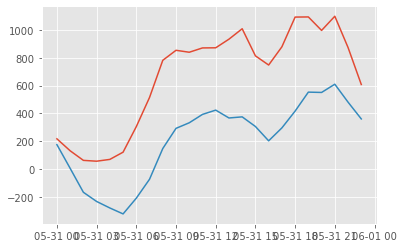

In [22]:
plt.plot(val)
plt.plot(forecast)

In [23]:
print('RMSE - ', rmse(val, forecast))
print('MAPE - ', mean_absolute_percentage_error(val, forecast))

RMSE -  479.3803030806802
MAPE -  128.56354218180576


Предсказания вообще выглядят довольно неадекватно, принимая значения даже меньше 0. Но посмотрим какое качество будет в среднем.

In [24]:
errors_rmse = []
errors_mape = []

tscv = TimeSeriesSplit(n_splits=10) 

for train_idx, test_idx in tscv.split(full_data[1231]):
    #print('len_train - ', len(train_idx))
    #print('len_test - ', len(test_idx))
    
    model = ExponentialSmoothing(full_data[1231][train_idx] ,seasonal_periods=24 , seasonal='add').fit()
    
    forecast = pd.Series(model.forecast(len(test_idx[:w_hours])))
    actual = full_data[1231][test_idx[:w_hours]] #из тестовой выборки берем всего лишь сутки, 
                                                 #т.к в итоге хотим предсказывать имеено такию длительность. 
    
    errors_rmse.append(rmse(actual.values, forecast.values))
    errors_mape.append(mean_absolute_percentage_error(actual.values, forecast.values))
        

In [25]:
np.mean(errors_mape), np.mean(errors_rmse)

(50.951444229587125, 247.88907037012495)

rmse меньше чем было раньше, посмотрим что можно с этим делать.

### Линейная модель + Arima на остатки

In [26]:
from sklearn.linear_model import LinearRegression, Ridge

Идея: давайте построим обычную линейную модель на придуманных нами регрессионных признаках. 
А информацию, которая останется в остатках от регресси, будем предсказывать с помощью ARIM'ы.
Конечно, можно передать регрессионные признаки в Arima (c помощью параметра exog), но Arima и так учится слишком большое количество времени, а прирост качества должен из-за этого быть очень незначительный.

В рамках моделей ARIMA можно учесть только одну из сезонностей.
    
Обычно в таких случаях сезонность с самым маленьким периодом явно моделируют с помощью аримы, а все остальные учитывают за счёт регрессионной компоненты.

Недельную сезонность будем учитывать с помощью гармонических признаков.

In [27]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler

In [47]:
def regression_matrix(data , T , K, lag_count, train_ind, test_ind): #матрица регрессионных признаков
    y_copy = pd.DataFrame(data)

    #делим выборку на 2 части
    y_copy.loc[y_copy.index[train_ind],'label'] = 'train'
    y_copy.loc[y_copy.index[test_ind],'label'] = 'test'
    
    matr_sin = np.zeros((T , K))
    matr_cos = np.zeros((T , K))
    
    for t in range(T):#гармонические признаки
        for i in range(K):
            matr_sin[t,i] = np.sin((t)*2*np.pi*i/168)
            matr_cos[t,i] = np.cos((t)*2*np.pi*i/168)

    #добавим индикатор дня недели 
    day_of_week = np.zeros((T , 1))
    
    for day_num in range(len(y_copy.index)): #нам важен только порядок дней недели
        day_of_week[k] = day_num % 7
    
    y_copy['day_of_week'] = day_of_week
    
    #добавим индикатор часа. 
    hour_id_day = np.zeros((T , 1))
    
    for k , index in enumerate(y_copy.index):
        hour_id_day[k] = index.hour
        
    y_copy['hour_id_day'] = hour_id_day

    # лаговые фичи
    lag_period = 24
    features = []
    for period_mult in range(1, lag_count, 1):
        y_copy["lag_period_{}".format(period_mult)] = y_copy[1231].shift(period_mult * lag_period)
        features.append("lag_period_{}".format(period_mult))

    #лаговые статистики
    y_copy['lagf_mean'] = y_copy[features].mean(axis = 1)
    
    target_encoder = TargetEncoder(cols = ['day_of_week','hour_id_day'], #сделаем таргет кодирование для дня недели и часа
                                   return_df = True)
    
    coding_train = target_encoder.fit_transform(y_copy[y_copy.label == 'train'].drop([1231, 'label'], axis = 1),
                                                y_copy[y_copy.label == 'train'][1231])
    
    coding_test = target_encoder.transform(y_copy[y_copy.label == 'test'].drop([1231, 'label'], axis = 1))

    scaler = StandardScaler() #сделаем нормализацию данных для линейной модели
    coding_train_scaler = scaler.fit_transform(coding_train)
    coding_test_scaler = scaler.transform(coding_test)
    
    #объединим все в одну матрицу
    return np.hstack((matr_sin, matr_cos, np.vstack((coding_train_scaler, coding_test_scaler))))
    

Теперь сделаем небольшую кросс-валидацию, для того чтобы подобрать параметры

   1. K - для признаков  $ sin([1,…,T] ∗ 2πi/168), \quad cos([1,…,T]∗2πi/168), i \in 1,...,K $, учитывающих недельную сезонность
   
   2. log_count - число лаговых фичей

In [53]:
def cross_validate_linear(K, lag_count):
    errors_rmse = []
    errors_mape = []

    tscv = TimeSeriesSplit(n_splits=10) 

    for train_idx, test_idx in tscv.split(full_data[1231]):
        len_ = len(train_idx) + len(test_idx)

        regression_feat = regression_matrix(full_data[1231][:len_], len_, K, lag_count, train_idx, test_idx)
        model = Ridge().fit(regression_feat[train_idx][lag_count * 24:],
                            full_data[1231][train_idx][lag_count * 24:]) #тут нужно обрезать строки с nan'ми

        forecast = model.predict(regression_feat[test_idx[:w_hours]]) #качество считаем не на всей тестовой выборке 
        actual = full_data[1231][test_idx[:w_hours]]                  #а на 24 часах, т.к это цель задания
        
        errors_rmse.append(rmse(actual.values, forecast))
        errors_mape.append(mean_absolute_percentage_error(actual.values, forecast))
    print(f'Params: K - {K}, lag_count - {lag_count}')
    print('Score:', np.mean(errors_mape[2:]), np.mean(errors_rmse[2:])) #тут берем с 2, т.к первые обучающие выборки 
                                                                        #совсем маленькие из-за убирания nan'oв

In [54]:
from sklearn.model_selection import ParameterGrid

In [55]:
params = ParameterGrid({'K': [4, 6, 8, 10, 12], 'lag_count': [6, 8, 10]})

In [56]:
for param in params:
    cross_validate_linear(*param.values())

Params: K - 4, lag_count - 6
Score: 23.53994949743754 126.5411026775684
Params: K - 4, lag_count - 8
Score: 13.577301735143065 82.13693606046408
Params: K - 4, lag_count - 10
Score: 13.288270959558732 82.38615649601738
Params: K - 6, lag_count - 6
Score: 19.324849845641232 117.36421408362536
Params: K - 6, lag_count - 8
Score: 12.566559810079541 79.05315274683944
Params: K - 6, lag_count - 10
Score: 12.268166731110279 80.92905058816396
Params: K - 8, lag_count - 6
Score: 19.1243358954262 116.43815933908186
Params: K - 8, lag_count - 8
Score: 12.76275593634327 80.75915729018604
Params: K - 8, lag_count - 10
Score: 12.375740796755583 81.91584450083727
Params: K - 10, lag_count - 6
Score: 17.946244635459294 110.43935508492929
Params: K - 10, lag_count - 8
Score: 12.557753790976477 80.82720016025164
Params: K - 10, lag_count - 10
Score: 12.597406533139516 82.37623315835833
Params: K - 12, lag_count - 6
Score: 17.062664385100494 108.45061331860413
Params: K - 12, lag_count - 8
Score: 11.880

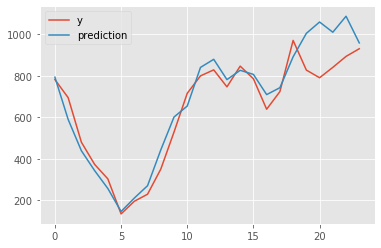

In [95]:
plt.plot(actual.values, label = 'y')
plt.plot(forecast, label = 'prediction')
plt.legend()

Теперь график выглядит очень похоже. 
Параметры возьмем K = 12, lag_count = 8.

Обучим такую модель на 3 месяцах и посмотрим остатки.

In [58]:
K = 12
lag_count = 8

In [86]:
train_idx = full_data.index.month != 5
test_idx = full_data.index.month == 5

In [60]:
regression_feat = regression_matrix(full_data[1231], T, K, lag_count, train_idx, test_idx)
model = Ridge().fit(regression_feat[train_idx][lag_count * 24:],
                    full_data[1231][train_idx][lag_count * 24:])

In [65]:
y_predict = model.predict(regression_feat[train_idx][lag_count * 24:])

Отрисуем график для трейна.

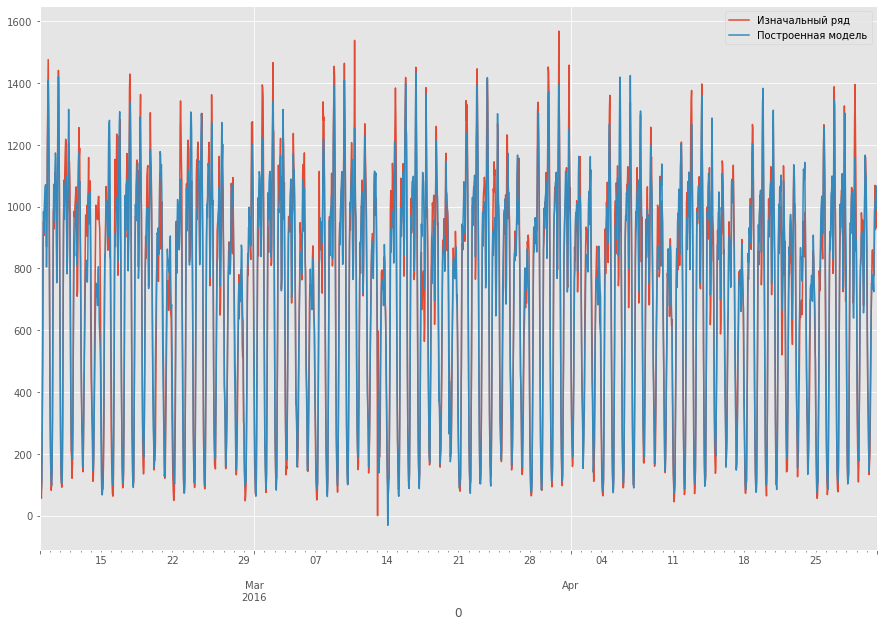

In [93]:
full_data[1231][train_idx][lag_count * 24:].plot(figsize = (15, 10), label = 'Изначальный ряд')
(y_residual + full_data[1231][train_idx][lag_count * 24:]).plot(label = 'Построенная модель')
plt.legend()

### Анализ остатков

In [130]:
y_residual = y_predict -  full_data[1231][train_idx][lag_count * 24:]

Text(0.5, 1.0, 'Остатки от линейной модели')

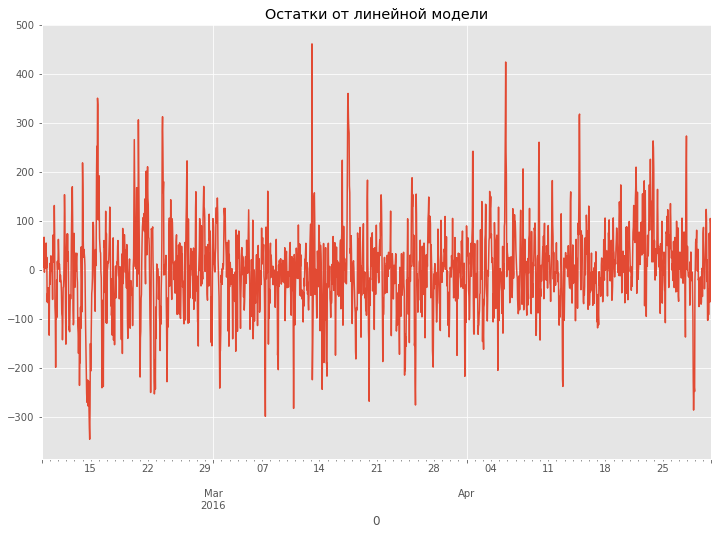

In [127]:
y_residual.plot(figsize = (12, 8))
plt.title('Остатки от линейной модели')

На самом деле остатки сильно напоминают белый шум. Явного тренда нет, сезонности тоже.

Проверим несмещенность остатков, с помощью критерия Стьюдента и стационарность с помощью критерия Дики-Фулера.

In [102]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(y_residual, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y_residual)[1])

Критерий Стьюдента: p=1.000000
Критерий Дики-Фуллера: p=0.000000


Как мы видим, остатки являются несмещенными и стационарными. Критерии уверенно это признают.

Вообще, на этом можно было бы остановиться, но давайте посмотрим, можно ли что-нибудь сделать с помощью Arim'ы

Отрисуем корролеллограммы.

In [136]:
y_residual = pd.DataFrame(y_residual)

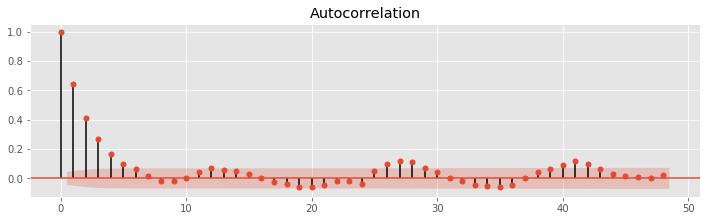

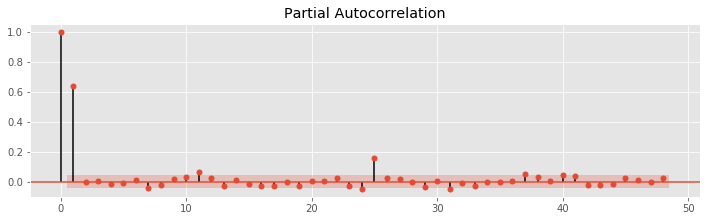

In [138]:
rcParams['figure.figsize'] = 12, 7
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(y_residual[1231], lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(y_residual[1231], lags=48, ax=ax)
plt.show()

Из графика автокорреляции все таки видно, что некоторая сезонность осталась в данных. Попробуем его продифференцировать.

In [142]:
y_residual['diff_24'] = y_residual[1231] - y_residual[1231].shift(24) #Первая сезонная  производная 

In [143]:
y_residual['diff_1'] = y_residual[1231] - y_residual[1231].shift(1) #Первая обычная производная 

In [145]:
y_residual.head()

,1231,diff_24,diff_1
0,,,
2016-02-09 00:00:00,118.315309,NaN,NaN
2016-02-09 01:00:00,49.352546,NaN,-68.962763
2016-02-09 02:00:00,49.514364,NaN,0.161818
2016-02-09 03:00:00,12.892994,NaN,-36.621370
2016-02-09 04:00:00,30.095321,NaN,17.202327


Еще раз отрисуем королеллограмму.

Для сезонной производной: 

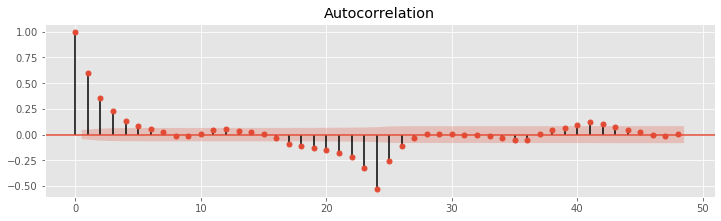

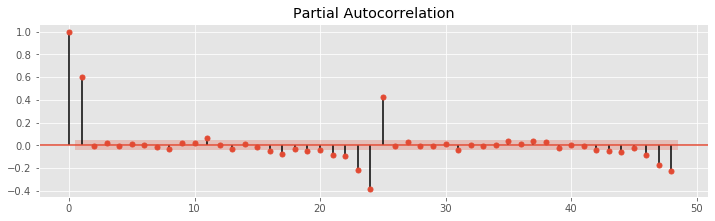

In [146]:
rcParams['figure.figsize'] = 12, 7
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(y_residual['diff_24'][24:], lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(y_residual['diff_24'][24:], lags=48, ax=ax)
plt.show()

Для обычной производной: 

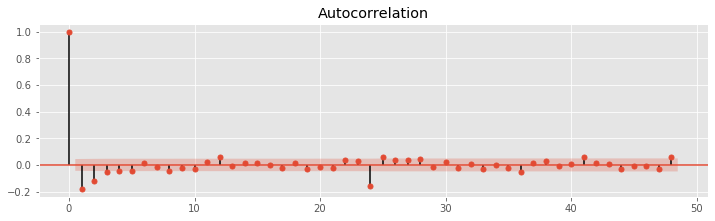

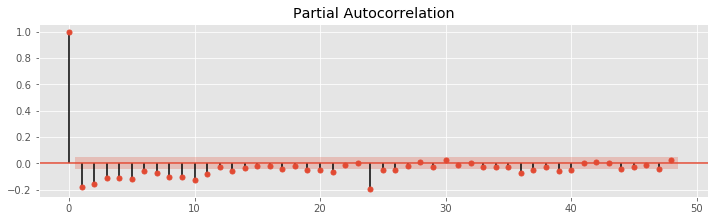

In [147]:
rcParams['figure.figsize'] = 12, 7
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(y_residual['diff_1'][1:], lags=48, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(y_residual['diff_1'][1:], lags=48, ax=ax)
plt.show()

Остановимся на обычной проиводной, т.к королеллограмма выглядит более независимой, чем для сезонного случая.

### Подбор параметров Arima

Из первого графика можно сделать вывод что: 

    Q = 1
    q= 1 или 2

Из второго графика:

    P = 1
    p - тоже возьмем не большим (попробуем 0 - 2), хотя значимых значений намного больше.
    
И параметры дифференцирования: 
 
    d = 1
    D = 0

In [148]:
ps = range(0, 3)
d = 1
qs = range(0, 3)
Ps = range(0,2)
D = 0
Qs = range(0,2)

In [149]:
from itertools import product

parameters = product(ps, qs, Ps,Qs)
parameters_list = list(parameters)
len(parameters_list)

36

Подберем параметры Arim'ы

In [150]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:

    try:
        model=sm.tsa.statespace.SARIMAX(y_residual[1231], order=(param[0], d, param[1]), 
                            seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)

    except:
        print('wrong parameters:', param)
        continue
    print('Ready:', param)
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Ready: (0, 0, 0, 0)
Ready: (0, 0, 0, 1)
Ready: (0, 0, 1, 0)
Ready: (0, 0, 1, 1)
Ready: (0, 1, 0, 0)
Ready: (0, 1, 0, 1)
Ready: (0, 1, 1, 0)
Ready: (0, 1, 1, 1)
Ready: (0, 2, 0, 0)
Ready: (0, 2, 0, 1)
Ready: (0, 2, 1, 0)
Ready: (0, 2, 1, 1)
Ready: (1, 0, 0, 0)
Ready: (1, 0, 0, 1)
Ready: (1, 0, 1, 0)
Ready: (1, 0, 1, 1)
Ready: (1, 1, 0, 0)
Ready: (1, 1, 0, 1)
Ready: (1, 1, 1, 0)
Ready: (1, 1, 1, 1)
Ready: (1, 2, 0, 0)
Ready: (1, 2, 0, 1)
Ready: (1, 2, 1, 0)
Ready: (1, 2, 1, 1)
Ready: (2, 0, 0, 0)
Ready: (2, 0, 0, 1)
Ready: (2, 0, 1, 0)
Ready: (2, 0, 1, 1)
Ready: (2, 1, 0, 0)
Ready: (2, 1, 0, 1)
Ready: (2, 1, 1, 0)
Ready: (2, 1, 1, 1)
Ready: (2, 2, 0, 0)
Ready: (2, 2, 0, 1)
Ready: (2, 2, 1, 0)
Ready: (2, 2, 1, 1)
Wall time: 2min 27s


In [151]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
18  (1, 1, 1, 0)  22071.578443
19  (1, 1, 1, 1)  22072.582149
30  (2, 1, 1, 0)  22073.566144
22  (1, 2, 1, 0)  22073.566168
23  (1, 2, 1, 1)  22074.560002


In [152]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                1231   No. Observations:                 1968
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 24)   Log Likelihood              -11031.789
Date:                             Sat, 12 Dec 2020   AIC                          22071.578
Time:                                     02:38:16   BIC                          22093.916
Sample:                                 02-09-2016   HQIC                         22079.787
                                      - 04-30-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6447      0.011     56.230      0.000       0.622       0.667
ma.L1         -0.9960      

В итоге лучшый набор параметров оказался 

    p = 1, q = 1, P = 1, Q = 0

Отрисуем финальные остатки.

Критерий Стьюдента: p=0.438464
Критерий Дики-Фуллера: p=0.000000


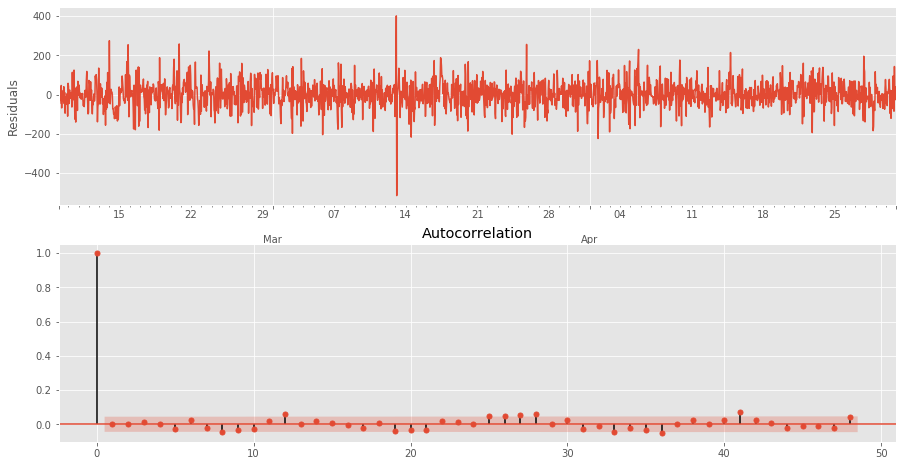

In [154]:
rcParams['figure.figsize'] = 15, 8
plt.subplot(211)
best_model.resid[1:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze() , lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[1:].values.squeeze() , 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

Теперь это точно белый шум. Они также не смещены и стационарны.

Давайте совместим линейную модель и Arim'у и проверим качество на кросс-валидации.

### Финальная модель.

In [156]:
K = 12
lag_count = 8
p = 1
q = 1
P = 1
Q = 0
d = 1
D = 0

In [178]:
errors_rmse = []
errors_mape = []

tscv = TimeSeriesSplit(n_splits=10) 

for train_idx, test_idx in tscv.split(full_data[1231]):
    len_ = len(train_idx) + len(test_idx)

    regression_feat = regression_matrix(full_data[1231][:len_], len_, K, lag_count, train_idx, test_idx)
    #обучаем линейную модель
    linear_model = Ridge().fit(regression_feat[train_idx][lag_count * 24:],
                                full_data[1231][train_idx][lag_count * 24:]) #тут нужно обрезать строки с nan'ми
    #считаем невязку
    residual = linear_model.predict(regression_feat[train_idx][lag_count * 24:]) - \
                                    full_data[1231][train_idx][lag_count * 24:]
    #обучам Arim'у
    arima_model = sm.tsa.statespace.SARIMAX(residual, order=(p, d, q), 
                                            seasonal_order=(P, D, Q, 24)).fit(disp=-1)
    
    #делаем предсказания линейной моделью
    forecast = linear_model.predict(regression_feat[test_idx[:w_hours]])  
    
    start_ind = len(train_idx[lag_count * 24:])#индекс начала предсказания

    # у нас y_true = y_pred - residual, поэтому вычитаем остатки
    forecast -= arima_model.predict(start = start_ind, end = start_ind + 23)
    
    actual = full_data[1231][test_idx[:w_hours]]                  
        
    errors_rmse.append(rmse(actual.values, forecast))
    errors_mape.append(mean_absolute_percentage_error(actual.values, forecast))

Посмотрим на результаты.

In [179]:
print(np.mean(errors_mape[2:]), np.mean(errors_rmse[2:])) 

11.490083216107912 80.45325307865804


Видно что качество не стало лучше. 

Было - Score: 11.880454673188066 80.4179657335404

Посмотрим на скор глазами.

In [181]:
errors_mape

[59.32325553829023,
 12.294116607224375,
 11.372000961378355,
 9.84529860261997,
 20.627729929000825,
 10.05814308300142,
 8.417277936190775,
 10.128144896850317,
 11.222562732876725,
 10.249507586944913]

Видно, что в целом ошибка составляет примерно 10%, но например бывают дни, в которые модель ошибается на все 20%.
(Не считая первые сплиты с маленьким трейном). 
Скорее всего, это является следствием того, что количество поездок на такси является очень шумным показателем, в том плане, что на него влияет очень много факторов, таких как, например, погода/пробки/праздники, которые не учитываются нашей моделью, но очень сильно могут влиять на спрос такси (значительно завышая/занижая его). Было бы интересно попробовать добавить подобные признаки, такие как предсказание синоптиков, в линейную модель).

Так что вполне возможно, что подобная точность в 11,5% является приемлимой.

Предсказание на один из последних дней выглядит как то так.

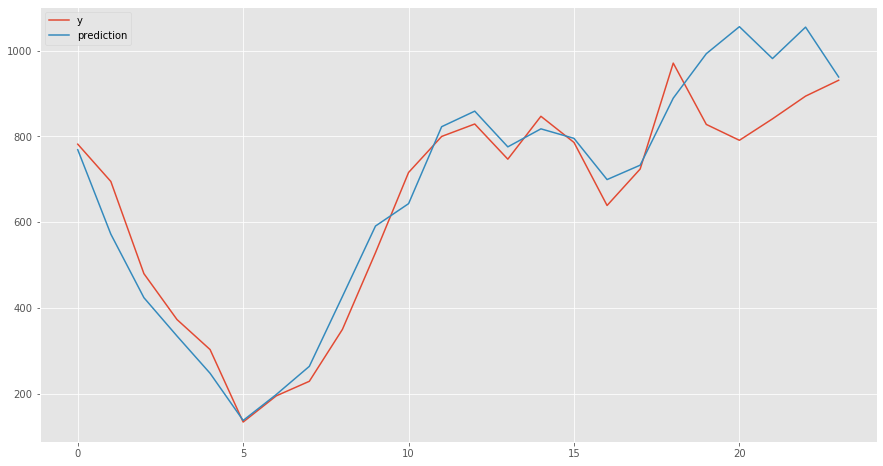

In [189]:
plt.plot(actual.values, label = 'y')
plt.plot(forecast.values, label = 'prediction')
plt.legend()

# Вывод

В данной работе мы решали задачу предсказания числа поездок такси в одном из центральных районов Нью-Йорка.

Выводы которые мы сделали в ходе знакомства с данными.
    
    1. Основня часть поездок на такси в Нью-Йорке осуществляется из Манхэтенна.
    
    2. Число поездок обладает, как дневной, так и недельной сезонностью. Это хорошо видно из графика.
    Также, мы можем предположить, что есть и годовая сезонность. 
    Потому что число поездок в майе в среднем меньше (это мы проверили несколькими критериями), чем 
    в предыдущие более холодные месяцы. Это кажется вполне логичным, т.к чем теплее, тем более вероятно человек выберет 
    пройтись пешком, вместо того чтобы брать такси.
    
    3. Поскольку ряд обладает сзонностью, то он не является стационарным. Однако, критерий Дики-Фулера, отвергает гипотезу     о нестационарности.
    
    4. Также, мы показали, что распределение числа поездок двумодальное, т.е люди катаются либо мало, либо много.
    И оно, очевидно, не нормальное.
    
    5. С помощью множественной проверки гипотез, мы показали что средние для различных месяцев отличаются.
    Средние равны, только для 2 и 3, 2 и 4 месяца.
   
Для предсказания ряда, мы использовали линейную модель. 

Мы сделали некоторые регрессионные признаки (день недели, час дня, лаги, гармонические признаки).

Проверяли качество на кросс-валидации. 

В итоге удалось получить качество MAPE = 11,88% 

Остатки от линейной модели оказались стационарными, несмещенными и похожими на белый шум.

Также мы попробовали обучить SARIMAX на остатках от линейной модели.
Это не дало значительного прироста в качестве (удалось достигнуть MAPE = 11,49%).

Если смотреть на качество на разных фолдах (в ходе кросс-валидации), то можно увидеть, что есть дни в которые качество значительно проседает. Скорее всего это следствие того, что целевая переменная - число поездок на такси, довольно зашумлена, т.к она зависит от многих случайных факторов (погоды, пробки и т.д). Поэтому, возможно, что для первого приближения это неплохое решение. 

Варианты улучшения: 

    1. Добавить, например, погодные признаки, индикаторы праздников и т.д
    2. Можно рассмотреть в качестве признаков число поездок в соседних ячейках, т.к скорее всего они сильно коррелируют.
    Это могло бы дать нам еще больше информации.
   
В данной задаче, решение с помощью линейной модели мне кажется оптимальным в плане простоты построения модели и настройки параметров. Ведь, изначально задача состояла в предсказании ряда для каждой из ячеек, и вариант, например, с построением модели ARIMA(или любой другой модели в которой надо кропотливо настраивать параметры) для каждой из 2500 ячеек кажется очень сомнительным.


P.S. За возможные грамматические ошибки прошу прощения.